In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [20]:
!pip install pycaret

In [79]:
#import modules
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [80]:
KAGGLE=False

In [26]:
if KAGGLE:
    path='../input/jobathonfebruary2022/'
else:
    path=''

In [27]:
train = pd.read_csv(path+'train_0OECtn8.csv')
test = pd.read_csv(path+'test_1zqHu22.csv')
subm = pd.read_csv(path+'sample_submission_JPlpRcN.csv')

In [28]:
print(train.shape)
print(test.shape)

(89197, 10)
(11121, 9)


In [29]:
def preproc(train,test):
    label_encoder = LabelEncoder()

    train['gender']= label_encoder.fit_transform(train['gender'])
    test['gender']= label_encoder.transform(test['gender'])
    
    #ordinal encoding of profession
    prof_map = {'Other':0,'Student':1,'Working Professional':2}
    train['profession'] = train['profession'].map(prof_map)
    test['profession'] = test['profession'].map(prof_map)

In [30]:
preproc(train,test)

In [31]:
targetcol = 'engagement_score'
target = train[targetcol]

In [198]:
exclude_cols =['row_id']
features =[col for col in train.columns if col not in exclude_cols]
print(len(features))
print(features)
features_excl_target = [col for col in features if col!=targetcol]

9
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'engagement_score']


In [199]:
# catcols = ['user_id','category_id','video_id','gender']
# catcols = ['category_id','video_id','gender']
catcols = ['gender']
numeric_cols = [col for col in features if col not in catcols+[targetcol]]
print(numeric_cols)

['user_id', 'category_id', 'video_id', 'age', 'profession', 'followers', 'views']


In [74]:
from pycaret.regression import *

In [200]:
preprocessor = ('Target encoding', TargetEncoder(cols=['user_id','category_id', 'video_id'],
                                                min_samples_leaf=2, smoothing=0.1) )

In [201]:
ce_target=TargetEncoder(cols=['user_id','category_id', 'video_id'],
                       min_samples_leaf=2, smoothing=0.1)
ce_target.fit(train,target)

ret =ce_target.transform(train,target)
ret.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,4.673280,3.314751,3.325765,24,1,1,180,1000,4.33
1,2,3.080000,3.442341,3.414046,14,0,1,330,714,1.79
2,3,4.193301,3.571666,3.478865,19,1,1,180,138,4.35
3,4,3.410004,3.955189,3.877502,19,1,1,220,613,3.77
4,5,3.152500,3.955189,3.877502,27,1,2,220,613,3.13


In [194]:
ret['user_id'].nunique()

6247

In [190]:
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,1,1,180,1000,4.33
1,2,5304,32,132,14,0,1,330,714,1.79
2,3,1840,12,24,19,1,1,180,138,4.35
3,4,12597,23,112,19,1,1,220,613,3.77
4,5,13626,23,112,27,1,2,220,613,3.13


In [202]:
s = setup(train[features], session_id=100,
          silent=True,
          numeric_features=numeric_cols,
          categorical_features=catcols,
          target = targetcol,
          custom_pipeline=preprocessor,
          fold=10,fold_shuffle=False,
#           high_cardinality_features=['user_id'],
#           high_cardinality_method='frequency',
#           preprocess=False,
#           use_gpu=True,
#           normalize=True,# normalize_method='minmax',
          )

,Description,Value
0,session_id,100
1,Target,engagement_score
2,Original Data,"(89197, 9)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(62437, 8)"


In [145]:
X_train = get_config('X_train')
print(len(X_train.columns))
X_train.columns

7


Index(['category_id', 'video_id', 'age', 'profession', 'followers', 'views',
       'gender_0'],
      dtype='object')

In [ ]:
# fold_gen=get_config('fold_generator')
# fold_gen
# X = get_config('X')
# y = get_config('y')

# for train_index, test_index in fold_gen.split(X):
#      print("TRAIN:", train_index, "TEST:", test_index)
#      tr, val = train.iloc[train_index], train.iloc[test_index]
#      print(val.shape)
#      print(val['user_id'].nunique())
#      print(val['video_id'].nunique())
#      print(val['category_id'].nunique())
#      y_tr, y_val = y[train_index], y[test_index]

In [203]:
%%time
lgbm = create_model('lightgbm')
lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5050,0.4740,0.6885,0.3920,0.1933,0.2429
1,0.5061,0.4615,0.6793,0.3743,0.1836,0.2429
2,0.5144,0.4864,0.6975,0.3691,0.1921,0.2821
3,0.5082,0.4663,0.6828,0.3686,0.1859,0.2265
4,0.5074,0.4721,0.6871,0.3773,0.1889,0.1977
5,0.5126,0.4805,0.6932,0.3556,0.1873,0.2263
6,0.5010,0.4524,0.6726,0.3805,0.1801,0.1922
7,0.5071,0.4686,0.6845,0.3773,0.1869,0.2341
8,0.4981,0.4487,0.6699,0.3801,0.1801,0.2387
9,0.5076,0.4678,0.6839,0.3812,0.1886,0.2603


CPU times: user 2.57 s, sys: 212 ms, total: 2.78 s
Wall time: 5.64 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

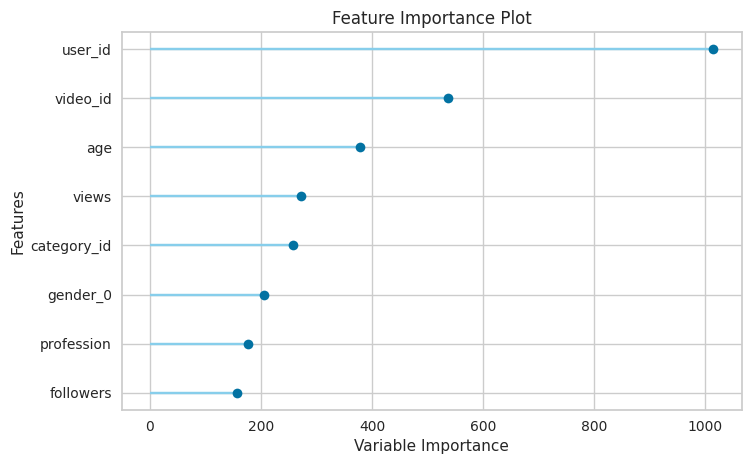

In [204]:
plot_model(lgbm,'feature')

In [205]:
%%time
# predict_model(lgbm)
final_model = finalize_model(lgbm)
test_preds = predict_model(final_model, data=test)
print(test_preds.head())

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0   89198     7986           12        42   14       1           1        180   
1   89199    11278           34       115   14       1           1        230   
2   89200    17245            8       110   44       0           2        280   
3   89201     9851           16       137   18       1           1        270   
4   89202    16008           34        96   47       0           0        230   

   views     Label  
0    138  4.112984  
1    840  4.053822  
2    628  2.280464  
3    462  2.774671  
4    840  2.028275  
CPU times: user 3.73 s, sys: 29 ms, total: 3.76 s
Wall time: 3.17 s


In [206]:
%%time
# predict_model(lgbm)
final_model = finalize_model(lgbm)
train_preds = predict_model(final_model, data=train)
print(train_preds.head())
print(r2_score(target,train_preds['Label']))

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0       1    19990           37       128   24       1           1        180   
1       2     5304           32       132   14       0           1        330   
2       3     1840           12        24   19       1           1        180   
3       4    12597           23       112   19       1           1        220   
4       5    13626           23       112   27       1           2        220   

   views  engagement_score     Label  
0   1000              4.33  4.601303  
1    714              1.79  2.944964  
2    138              4.35  4.294389  
3    613              3.77  3.526533  
4    613              3.13  3.304621  
0.6860737121862293
CPU times: user 4.02 s, sys: 31 ms, total: 4.05 s
Wall time: 3.22 s


In [207]:
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

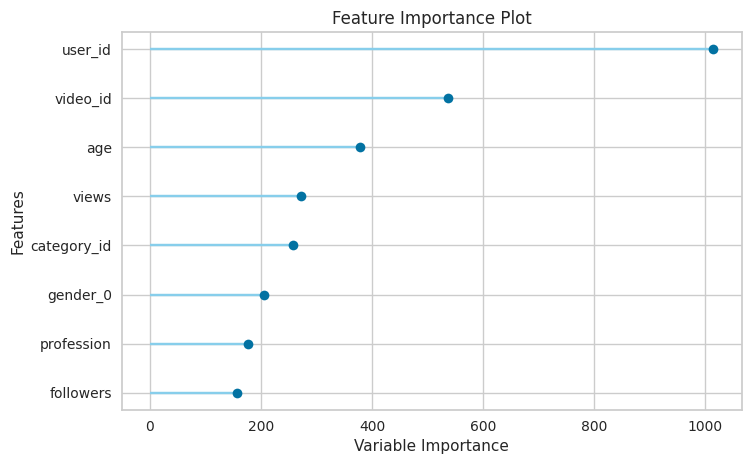

In [208]:
plot_model(lgbm,'feature')

In [209]:
submission = test_preds[['row_id','Label']]
submission=submission.rename(columns={'Label':'engagement_score'})
submission[['row_id','engagement_score']].to_csv('submission.csv',index=False)

In [210]:
test_sub = pd.read_csv('submission.csv')

In [211]:
print(test_sub.shape)
test_sub.head()

(11121, 2)


,row_id,engagement_score
0,89198,4.112984
1,89199,4.053822
2,89200,2.280464
3,89201,2.774671
4,89202,2.028275
